# Solving a single-channel CBPDN problem using SPORCO

This notebook demonstrates the use of SPORCO to solve a Convolutional Basis Pursuit DeNoising (CBPDN) problem with a greyscale signal

$$\mathrm{argmin}_\mathbf{x} \; (1/2) \left\| \sum_m \mathbf{d}_m * \mathbf{x}_{m} - \mathbf{s} \right\|_2^2 + \lambda \sum_m \| \mathbf{x}_{m} \|_1$$

where $\mathbf{d}_{m}$ is the $m^{\text{th}}$ dictionary filter, $\mathbf{x}_{m}$ is the coefficient map corresponding to the $m^{\text{th}}$ dictionary filter, and $\mathbf{s}$ is the input image.



Import modules and configure matplotlib output to notebook.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco import util
from sporco import plot
import sporco.linalg as spl
from sporco.admm import cbpdn

%matplotlib inline

Load test image and compute lowpass and highpass components.

In [2]:
# Load test image
img = util.ExampleImages().image('lena.grey', scaled=True, zoom=0.5)

# Highpass filter test image
npd = 16
fltlmbd = 10
sl, sh = util.tikhonov_filter(img, fltlmbd, npd)

Load colour dictionary and display it.

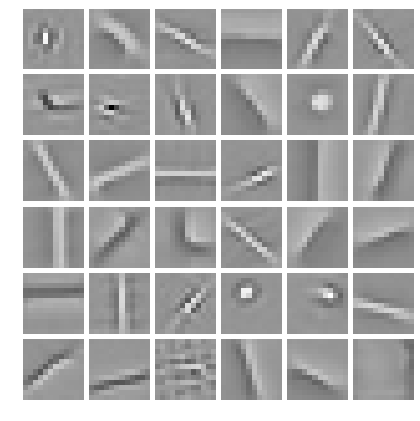

In [3]:
# Load dictionary
D = util.convdicts()['G:12x12x36']

# Display dictionary
fig = plot.figure(figsize=(7,7))
fgax = plot.imview(util.tiledict(D), fgrf=fig)

Set CBPDN solver class options.

In [4]:
# Set up ConvBPDN options
lmbda = 5e-2
opt = cbpdn.ConvBPDN.Options({'Verbose' : True, 'MaxMainIter' : 200,
                              'LinSolveCheck' : True, 'RelStopTol' : 1e-3,
                              'AuxVarObj' : False})

Initialise and run CBPDN solver and then reconstruct image from sparse representation.

In [5]:
# Solve CBPDN problem
b = cbpdn.ConvBPDN(D, sh, lmbda, opt, dimK=0)
X = b.solve()

print("ConvBPDN solve time: %.2fs" % b.runtime)

# Reconstruct representation
shr = b.reconstruct().squeeze()
imgr = sl + shr
print("Reconstruction PSNR: %.2fdB\n" % spl.psnr(img, imgr))

Itn   Fnc       DFid      Regℓ1     r         s         ρ         
----------------------------------------------------------------
   0  9.62e+01  2.28e+00  1.88e+03  9.23e-01  1.77e-01  3.50e+00
   1  7.89e+01  7.78e+00  1.42e+03  6.28e-01  3.09e-01  3.50e+00
   2  7.06e+01  8.73e+00  1.24e+03  3.09e-01  2.94e-01  4.19e+00
   3  7.20e+01  8.34e+00  1.27e+03  2.39e-01  2.23e-01  3.62e+00
   4  6.85e+01  7.85e+00  1.21e+03  2.09e-01  1.59e-01  3.15e+00
   5  6.06e+01  7.88e+00  1.05e+03  1.72e-01  1.27e-01  3.15e+00
   6  5.48e+01  8.07e+00  9.36e+02  1.42e-01  1.00e-01  3.15e+00
   7  5.18e+01  8.29e+00  8.69e+02  1.15e-01  8.14e-02  3.15e+00
   8  5.01e+01  8.40e+00  8.34e+02  9.34e-02  7.08e-02  3.15e+00
   9  4.92e+01  8.43e+00  8.15e+02  7.82e-02  6.18e-02  3.15e+00
  10  4.78e+01  8.42e+00  7.88e+02  6.69e-02  5.51e-02  3.15e+00
  11  4.64e+01  8.43e+00  7.59e+02  5.81e-02  4.96e-02  3.15e+00
  12  4.53e+01  8.46e+00  7.36e+02  5.39e-02  4.38e-02  2.86e+00
  13  4.43e+01  8.50e+0

Display low pass component and sum of absolute values of coefficient maps of highpass component.

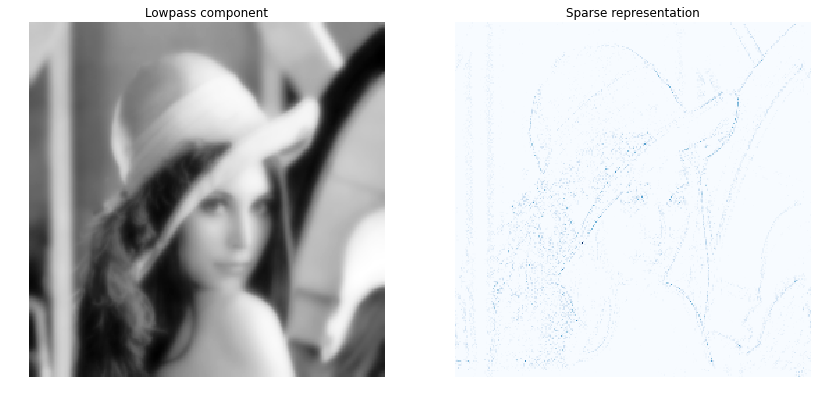

In [6]:
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(sl, title='Lowpass component', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(np.sum(abs(X), axis=b.cri.axisM).squeeze(), cmap=plot.cm.Blues,
            title='Sparse representation', fgrf=fig)

Display original and reconstructed images.

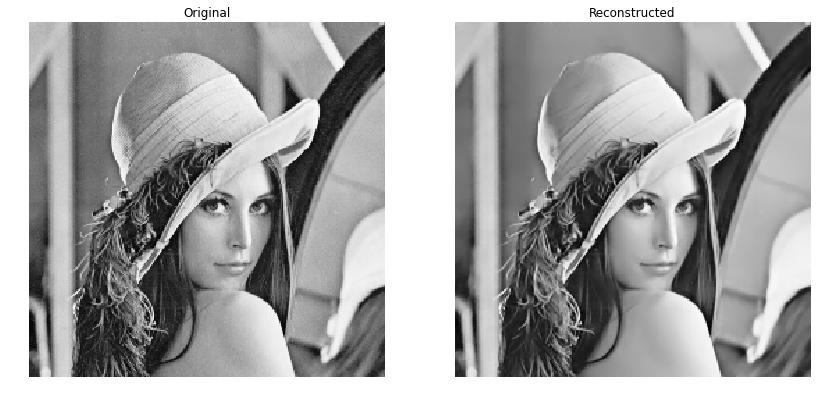

In [7]:
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(img, title='Original', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(imgr, title='Reconstructed', fgrf=fig)

Plot functional evolution during ADMM iterations.

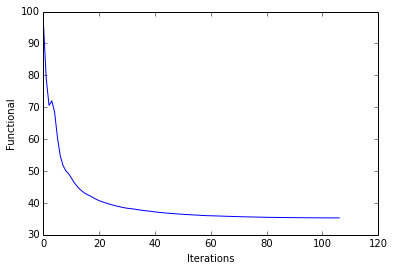

In [8]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')
plot.close()

Plot evolution of ADMM residuals and ADMM penalty parameter.

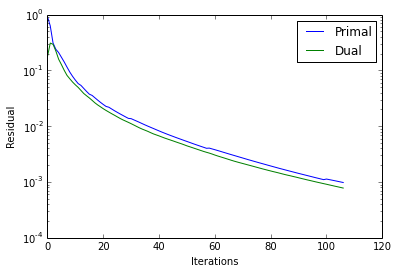

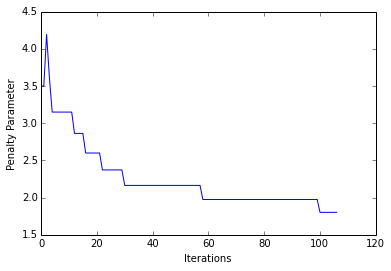

In [9]:
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual']);
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')
plot.close()